In [ ]:
# !pip install transformers

In [1]:
import os, gc, sys, time, collections, random
import numpy as np
import pandas as pd

from typing import Dict, Optional, Union, Any, List, Tuple

from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn

import torch.utils.data as D
from torch.utils.data.dataset import Dataset, IterableDataset
from torch.utils.data.dataloader import DataLoader

from transformers import DistilBertTokenizerFast
from transformers import DistilBertModel
from transformers import BertTokenizerFast
from transformers import BertModel
from transformers import Trainer
from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers.data.processors.utils import InputFeatures
from transformers import TrainingArguments
from transformers.trainer_utils import EvalLoopOutput
from transformers.trainer import logging
from transformers.file_utils import is_torch_tpu_available, is_sagemaker_mp_enabled
from transformers.trainer_pt_utils import find_batch_size, nested_concat, nested_numpify, nested_truncate, nested_detach

### Folders and Dataframes

In [2]:
DATA_PATH = Path('/home/commonlit/data/')
assert DATA_PATH.exists()
MODELS_PATH = Path('/home/commonlit/models/')
if not MODELS_PATH.exists():
    os.mkdir(MODELS_PATH)
assert MODELS_PATH.exists()

In [3]:
!ls {DATA_PATH}

commonlit_lm		       sample_submission.csv  train-orig.csv
commonlitreadabilityprize.zip  test.csv		      train.csv


In [4]:
train_df = pd.read_csv(DATA_PATH/'train.csv')
test_df = pd.read_csv(DATA_PATH/'test.csv')
sample_df = pd.read_csv(DATA_PATH/'sample_submission.csv')

In [5]:
train_df

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
2,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
3,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
4,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
...,...,...,...,...,...,...
2838,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
2839,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648
2840,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866
2841,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128


In [6]:
train_df[train_df['excerpt'].str.contains('Holstein')]

,id,url_legal,license,excerpt,target,standard_error
1298,0bf29d257,NaN,NaN,The truth stands that the whole Schleswig-Hols...,-3.351956,0.554593


In [7]:
train_df[train_df['id'] == '0bf29d257']['excerpt'].values

array(['The truth stands that the whole Schleswig-Holstein question is one that involves the modern principle of "nationality," and, as such, enters of necessity into the present European crisis. It is broadly understood by Dr. Eliot and willfully misapprehended by his critic.\nPassing on to consider Alsace-Lorraine, Dr. Dernburg declares that "it had belonged to Germany until it was taken, against the will of the people, under Louis XIV."\nIn this statement, as in the treatment of the previous question, facts are mutilated and wrong impressions are given. Alsace, it is well known, was included within the confines of ancient Gaul, its original population was Celtic, and it passed, late in the fifth Christian century, under the rule of the Franks, one of whose chieftains, Clovis, became the founder of the first French monarchy. In dealing with its later history Dr. Dernburg confuses the Holy Roman (Germanic) Empire with Germany, considered in its modern sense. He appears to forget that 

In [8]:
train_df[train_df['id'] == '0bf29d257']['target']

1298   -3.351956
1299   -3.351956
Name: target, dtype: float64

In [11]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 285 kB 5.8 MB/s eta 0:00:01


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target'>

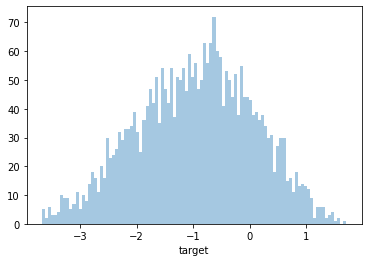

In [13]:
sns.distplot(train_df['target'],bins=100,kde=False)

### Prepare Cross Validation

In [14]:
target = train_df['target'].to_numpy()

In [15]:
num_bins = int(np.floor(np.log2(len(train_df))) + 1)
train_df.loc[:, 'bins'] = pd.cut(train_df['target'], bins=num_bins, labels=False)

In [16]:
train_df[['target', 'bins']].groupby(['bins']).agg(['mean', 'count'])

target      
          mean count
bins                
0    -3.411708    44
1    -2.969369    79
2    -2.526589   172
3    -2.106393   269
4    -1.652726   366
5    -1.201150   419
6    -0.748612   484
7    -0.309570   408
8     0.130016   312
9     0.560802   184
10    0.978923    83
11    1.399764    23

In [17]:
kf = StratifiedKFold(n_splits=num_bins)

In [18]:
for i, (t_, v_) in enumerate(kf.split(X=train_df, y=train_df.bins.values)):
    train_df.loc[v_, 'kfold'] = i

In [19]:
train_df['kfold'] = train_df['kfold'].astype(np.uint8)

In [20]:
train_df = train_df.drop('bins', axis=1)

In [21]:
train_df

,id,url_legal,license,excerpt,target,standard_error,kfold
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0
1,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0
2,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,0
3,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,0
4,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,0
...,...,...,...,...,...,...,...
2838,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900,11
2839,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648,11
2840,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866,11
2841,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128,11


In [22]:
bin_list = list(range(num_bins))
random.shuffle(bin_list)
bin_list

[6, 7, 9, 8, 2, 1, 3, 5, 0, 10, 4, 11]

### Metrics

In [23]:
def rmse_score(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

def rmse_score_2(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [24]:
a = np.random.rand(10)
b = np.random.rand(10)

In [25]:
rmse_score(a, b), rmse_score_2(a, b)

(0.37768242355286086, 0.37768242355286086)

### Configuration

In [26]:
!mv /home/commonlit/models/roberta-base-lm /home/commonlit/models/roberta-base_lm

mv: cannot stat '/home/commonlit/models/roberta-base-lm': No such file or directory


In [27]:
class CONFIG():
    model_name = 'roberta-base'
    batch_size = 80
    max_len = 256
    save_dir = f'trained/{model_name}'
    num_workers = 4
    epochs = 30
    pretrained_transformers_model = f'/home/commonlit/models/{model_name}_lm/best_model'

In [28]:
cfg = CONFIG()

### Prepare train test split

In [29]:
def create_split(fold = [1]):
    valid_df = train_df[train_df['kfold'].isin(fold)]
    valid_text = valid_df['excerpt'].values
    valid_target = valid_df['target'].values
    training_df = train_df[~train_df['kfold'].isin(fold)]
    train_text = training_df['excerpt'].values
    train_target = training_df['target'].values
    return train_text, train_target, valid_text, valid_target

In [30]:
train_text, train_target, valid_text, valid_target = create_split([0])
len(train_text), len(valid_text)

(2606, 237)

### Prepare Tokenizers

In [31]:
tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)
# Save the tokenizer so that you can download the files and move it to a Kaggle dataset.
tokenizer.save_pretrained(cfg.save_dir)

('trained/roberta-base/tokenizer_config.json',
 'trained/roberta-base/special_tokens_map.json',
 'trained/roberta-base/vocab.json',
 'trained/roberta-base/merges.txt',
 'trained/roberta-base/added_tokens.json',
 'trained/roberta-base/tokenizer.json')

In [32]:
encoded_dict = tokenizer(train_df['excerpt'].values[0],
                                return_tensors='pt',
                                max_length=cfg.max_len,
                                padding='max_length',
                                truncation=True)
decoded = tokenizer.decode(encoded_dict["input_ids"].squeeze())
decoded

'<s>When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes

In [33]:
encoded_dict['input_ids'].shape

torch.Size([1, 256])

In [34]:
def convert_to_list(t):
    return t.flatten().long()

class CommonLitDataset(nn.Module):
    def __init__(self, text, target, tokenizer, max_len=128):
        self.excerpt = text
        self.target = target
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self, idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        return InputFeatures(input_ids=convert_to_list(encode['input_ids']),
                      attention_mask=convert_to_list(encode['attention_mask']),
                      label=torch.tensor(self.target[idx]))
    
    def __len__(self):
        return len(self.excerpt)

In [35]:
def create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target):
    train_ds = CommonLitDataset(train_text, train_target, tokenizer, cfg.max_len)
    valid_ds = CommonLitDataset(valid_text, valid_target, tokenizer, cfg.max_len)
    return train_ds, valid_ds

In [36]:
# encode.keys(), target.shape, encode['input_ids'].shape, encode['attention_mask'].shape

In [37]:
# encode['input_ids'][0].squeeze()

### Model

In [38]:
# You can use a Transformer model of your choice.
# transformer_model = DistilBertModel.from_pretrained(cfg.pretrained_transformers_model)
transformer_model = AutoModel.from_pretrained(cfg.pretrained_transformers_model)

Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably

In [39]:
# transformer_out = transformer_model(input_ids=encode['input_ids'].squeeze(), attention_mask=encode['attention_mask'].squeeze())

In [40]:
# dict(transformer_out)['last_hidden_state'].shape

In [41]:
# torch.mean(transformer_out.last_hidden_state, axis=1).shape

In [42]:
# sample_layer = nn.Linear(768, 1)

In [43]:
model_config = AutoConfig.from_pretrained(cfg.pretrained_transformers_model)

In [44]:
model_config

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [45]:
from torch.nn import functional as F

In [46]:
from transformers import PreTrainedModel

class CommonLitModel(PreTrainedModel):
    def __init__(self):
        super(PreTrainedModel, self).__init__()
        self.transformer_model = AutoModel.from_pretrained(cfg.pretrained_transformers_model)
        self.drop = nn.Dropout(0.5)
        self.config = AutoConfig.from_pretrained(cfg.pretrained_transformers_model)
        self.layer_norm = nn.LayerNorm(self.config.hidden_size)
        self.out = nn.Linear(self.config.hidden_size, 1)
#         self._init_weights(self.layer_norm)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def forward(self, input_ids, attention_mask):
        transformer_out = self.transformer_model(input_ids=input_ids.squeeze(), attention_mask=attention_mask.squeeze(), output_hidden_states=False)
        x = transformer_out.pooler_output
#         x = transformer_out.last_hidden_state[:, 0, :] # N, C, X
        x = self.layer_norm(x)
        x = self.drop(x)
        x = self.out(x)
        return x
    
    def floating_point_ops(self, inputs: Dict[str, Union[torch.Tensor, Any]]):
        """
        For models that inherit from :class:`~transformers.PreTrainedModel`, uses that method to compute the number of
        floating point operations for every backward + forward pass. If using another model, either implement such a
        method in the model or subclass and override this method.
        Args:
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.
        Returns:
            :obj:`int`: The number of floating-point operations.
        """
        return 0

In [47]:
model = CommonLitModel()

Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably

In [48]:
encoded_dict.input_ids.shape

torch.Size([1, 256])

In [49]:
transformer_model = transformer_model.cuda()
sample_out = transformer_model(encoded_dict.input_ids.cuda(), encoded_dict.attention_mask.cuda(), output_hidden_states=True)

In [50]:
sample_out.pooler_output.shape

torch.Size([1, 768])

In [51]:
sample_out.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])

In [52]:
sample_out['last_hidden_state'].shape, sample_out['last_hidden_state'][:, 0].shape

(torch.Size([1, 256, 768]), torch.Size([1, 768]))

In [53]:
train_ds, valid_ds = create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target)

In [54]:
encode = train_ds[0]

In [55]:
encode.attention_mask.unsqueeze(0).shape, encoded_dict.input_ids.shape

(torch.Size([1, 256]), torch.Size([1, 256]))

In [56]:
sample_out = transformer_model(encode.input_ids.unsqueeze(0).cuda(), encode.attention_mask.unsqueeze(0).cuda())

### Training

In [57]:
import wandb

In [60]:
criterion = nn.MSELoss()

kl_loss = nn.KLDivLoss(reduction = 'batchmean')

def loss_fct(yhat, y):
    return criterion(yhat, y) * 0.7 + 0.3 * kl_loss(yhat, y)

In [61]:
def create_training_args(fold):
    training_args = TrainingArguments(
        output_dir=str(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{fold}"),
        overwrite_output_dir=True,
        do_train=True,
        do_eval=True,
        per_device_train_batch_size=cfg.batch_size,
        per_device_eval_batch_size=cfg.batch_size,
        num_train_epochs=cfg.epochs,
        logging_strategy="epoch",
        logging_first_step=True,
        save_steps=40000,
        fp16=True,
        evaluation_strategy="epoch",
        save_total_limit = 3,
        load_best_model_at_end=True,
        metric_for_best_model='mse',
        greater_is_better=False,
        gradient_accumulation_steps=1,
        learning_rate=5e-5
    )
    return training_args

In [62]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    return {'mse': mean_squared_error(logits, labels), 'rmse': rmse_score_2(logits, labels)}

In [63]:
tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)

In [64]:
logger = logging.get_logger(__name__)

class CommonLitTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        input_ids = inputs.pop("input_ids")
        attention_mask = inputs.pop("attention_mask")
        outputs = model(input_ids, attention_mask)
        logits = outputs
        loss = loss_fct(logits.flatten(),
                        labels.float().flatten())
        zero_cat = torch.zeros([1, 1]).to(outputs.device)
        return (loss, torch.cat([zero_cat, outputs])) if return_outputs else loss

In [65]:
cfg.model_name

'roberta-base'

In [66]:
!rm -rf /home/commonlit/models/{cfg.model_name.replace('/', '_')}-*

In [67]:
%%time

from transformers import EarlyStoppingCallback

bin_step = 1
bestmodels = []
eval_rmses = []
for i in range(0, num_bins, bin_step):
    train_bins = bin_list[i:i+bin_step]
    print('train_bins', f'{i}: {train_bins}')
    tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)
    train_text, train_target, valid_text, valid_target = create_split([i])
    train_ds, valid_ds = create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target)
    training_args = create_training_args(i)
    model = CommonLitModel()
    wandb.init(project=f"commonlit_{cfg.model_name.replace('/', '_')}")
    trainer = CommonLitTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=12)]
    )
    trainer.train()
    trainer.save_model()
    print('training_args.output_dir', training_args.output_dir)
    tokenizer.save_pretrained(training_args.output_dir)
    result = trainer.evaluate()
    bestmodels.append(trainer.state.best_model_checkpoint)
    print('best_model_checkpoint', trainer.state.best_model_checkpoint)
    print('result', result)
    eval_rmses.append(result['eval_rmse'])

train_bins 0: [6]


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably

Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.646200,0.546133,0.819488,0.905256
2,0.374800,0.360742,0.537610,0.733219
3,0.268900,0.667145,1.001461,1.000730
4,0.212500,0.329964,0.500634,0.707555
5,0.158500,0.451059,0.691224,0.831399
6,0.139400,0.273841,0.426003,0.652689
7,0.109000,0.186370,0.293228,0.541506
8,0.110400,0.277232,0.432994,0.658023
9,0.078200,0.244799,0.381776,0.617880
10,0.055800,0.295931,0.457094,0.676087


training_args.output_dir /home/commonlit/models/roberta-base-0


best_model_checkpoint /home/commonlit/models/roberta-base-0/checkpoint-231
result {'eval_loss': 0.18636995553970337, 'eval_mse': 0.29322826862335205, 'eval_rmse': 0.5415055751800537, 'eval_runtime': 1.3698, 'eval_samples_per_second': 173.016, 'epoch': 19.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 944294400}
train_bins 1: [7]


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably

train/loss,0.0126
train/learning_rate,2e-05
train/epoch,19.0
train/global_step,627
_runtime,472
_timestamp,1623136117
_step,40
eval/loss,0.18637
eval/mse,0.29323
eval/rmse,0.54151
eval/runtime,1.3698


train/loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
eval/loss,▆▄█▃▅▂▁▂▂▃▃▃▄▃▄▄▃▃▅▁
eval/mse,▆▃█▃▅▂▁▂▂▃▃▃▄▃▅▄▃▃▅▁
eval/rmse,▇▄█▄▅▃▁▃▂▃▃▃▄▃▅▄▃▃▅▁
eval/runtime,▁▃▄▅▄▇▇▄▄▄▄▆▄▅▇▅▄▄▄█


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.624500,0.306640,0.475922,0.689871
2,0.373500,0.348369,0.528555,0.727018
3,0.293400,0.327945,0.515928,0.718281
4,0.199300,0.181682,0.284459,0.533347
5,0.203700,0.172595,0.285797,0.534600
6,0.138100,0.363332,0.558792,0.747524
7,0.137600,0.685532,1.041443,1.020511
8,0.119200,0.655032,1.001409,1.000704
9,0.098500,0.277969,0.440992,0.664072
10,0.059500,0.295766,0.471463,0.686632


training_args.output_dir /home/commonlit/models/roberta-base-1


best_model_checkpoint /home/commonlit/models/roberta-base-1/checkpoint-132
result {'eval_loss': 0.18168222904205322, 'eval_mse': 0.28445878624916077, 'eval_rmse': 0.5333467721939087, 'eval_runtime': 1.349, 'eval_samples_per_second': 175.681, 'epoch': 16.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 944294400}
train_bins 2: [9]


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably

train/loss,0.0265
train/learning_rate,2e-05
train/epoch,16.0
train/global_step,528
_runtime,398
_timestamp,1623136522
_step,34
eval/loss,0.18168
eval/mse,0.28446
eval/rmse,0.53335
eval/runtime,1.349


train/loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▆▆▅▅▅▄▄▃▃▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
eval/loss,▃▃▃▁▁▄██▂▃▁▂▂▁▂▂▁
eval/mse,▃▃▃▁▁▄██▂▃▁▂▂▁▂▂▁
eval/rmse,▃▄▄▁▁▄██▃▃▁▃▂▁▂▂▁
eval/runtime,▁▂▃▃▂▂▂██▃▃▃▂▇▃█▃


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.713100,0.260315,0.399394,0.631976
2,0.335000,0.279685,0.440268,0.663527
3,0.254500,0.333106,0.521964,0.722471
4,0.205200,0.242758,0.379198,0.615790
5,0.158000,0.210237,0.337359,0.580826
6,0.145800,0.397767,0.619466,0.787061
7,0.091200,0.247155,0.396361,0.629572
8,0.085500,0.211005,0.337172,0.580665
9,0.061400,0.288170,0.453263,0.673248
10,0.050700,0.340944,0.533303,0.730276


training_args.output_dir /home/commonlit/models/roberta-base-2


best_model_checkpoint /home/commonlit/models/roberta-base-2/checkpoint-462
result {'eval_loss': 0.18569952249526978, 'eval_mse': 0.29762884974479675, 'eval_rmse': 0.5455536842346191, 'eval_runtime': 1.3428, 'eval_samples_per_second': 176.497, 'epoch': 26.0, 'eval_mem_cpu_alloc_delta': 4096, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 944294400}
train_bins 3: [8]


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably

train/loss,-0.0048
train/learning_rate,1e-05
train/epoch,26.0
train/global_step,858
_runtime,642
_timestamp,1623137170
_step,54
eval/loss,0.1857
eval/mse,0.29763
eval/rmse,0.54555
eval/runtime,1.3428


train/loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eval/loss,▃▄▆▃▂█▃▂▄▆▃▂▆▁▃▂▃▄▃▄▂▄▄▃▃▂▁
eval/mse,▃▄▆▃▂█▃▂▄▆▃▂▆▁▃▂▃▅▃▅▂▄▄▄▄▂▁
eval/rmse,▄▄▆▃▂█▃▂▅▆▃▂▆▁▃▃▃▅▃▅▂▅▅▄▄▃▁
eval/runtime,▁▂▂▂▂▂▂▂█▁▂▂▂▂▁▂█▂▂▂▁▂▂▂▂▂▁


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.762100,0.241611,0.354995,0.595814
2,0.340800,0.332728,0.507159,0.712151
3,0.248800,0.420803,0.641059,0.800662
4,0.192000,0.430993,0.661388,0.813257
5,0.134400,0.458389,0.705538,0.839963
6,0.121500,0.311932,0.491559,0.701113
7,0.097900,0.372899,0.578419,0.760539
8,0.076200,0.320450,0.508960,0.713414
9,0.069200,0.187584,0.298378,0.546240
10,0.062600,0.309582,0.486694,0.697635


training_args.output_dir /home/commonlit/models/roberta-base-3


best_model_checkpoint /home/commonlit/models/roberta-base-3/checkpoint-297
result {'eval_loss': 0.18758359551429749, 'eval_mse': 0.2983780801296234, 'eval_rmse': 0.546239972114563, 'eval_runtime': 1.3525, 'eval_samples_per_second': 175.236, 'epoch': 21.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 944294400}
train_bins 4: [2]


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably

train/loss,0.0022
train/learning_rate,2e-05
train/epoch,21.0
train/global_step,693
_runtime,520
_timestamp,1623137697
_step,44
eval/loss,0.18758
eval/mse,0.29838
eval/rmse,0.54624
eval/runtime,1.3525


train/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eval/loss,▂▄▆▆▇▄▅▄▁▄▄▆▆▇▄▄█▇▂▄▄▁
eval/mse,▂▄▆▆▇▄▅▄▁▄▄▆▆▇▄▄█▇▂▄▄▁
eval/rmse,▂▄▆▆▇▄▅▄▁▄▄▆▆▇▄▅█▇▂▄▅▁
eval/runtime,▁▁▂█▁▁▁▂▃▂▂▂▂▃▂▃▂▂▂▂▃▂


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.816000,0.177815,0.280496,0.529619
2,0.346700,0.174429,0.274868,0.524279
3,0.258800,0.226558,0.366527,0.605415
4,0.225500,0.275448,0.435532,0.659948
5,0.164200,0.242846,0.389705,0.624263
6,0.117500,0.413412,0.640814,0.800508
7,0.091100,0.230060,0.379071,0.615687
8,0.063700,0.220682,0.354177,0.595128
9,0.076400,0.278433,0.451284,0.671777
10,0.082800,0.262277,0.425660,0.652426


training_args.output_dir /home/commonlit/models/roberta-base-4


best_model_checkpoint /home/commonlit/models/roberta-base-4/checkpoint-66
result {'eval_loss': 0.17442858219146729, 'eval_mse': 0.2748684287071228, 'eval_rmse': 0.5242789387702942, 'eval_runtime': 1.3535, 'eval_samples_per_second': 175.097, 'epoch': 14.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 945080832}
train_bins 5: [1]


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably

train/loss,0.0219
train/learning_rate,3e-05
train/epoch,14.0
train/global_step,462
_runtime,349
_timestamp,1623138052
_step,30
eval/loss,0.17443
eval/mse,0.27487
eval/rmse,0.52428
eval/runtime,1.3535


train/loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▆▆▅▅▄▄▃▃▂▂▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
eval/loss,▁▁▃▄▃█▃▂▄▄▅▂▄▇▁
eval/mse,▁▁▃▄▃█▃▃▄▄▅▂▄▇▁
eval/rmse,▁▁▃▄▄█▃▃▅▄▅▃▄▇▁
eval/runtime,▁▂▂▂▂▃▃▂██▂▃▃▂▃


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.824600,0.396911,0.601276,0.775420
2,0.408000,0.181512,0.299512,0.547277
3,0.263900,0.165410,0.277890,0.527152
4,0.235000,0.593483,0.911856,0.954912
5,0.191900,0.198760,0.327780,0.572521
6,0.129800,0.199829,0.336414,0.580012
7,0.097200,0.125864,0.218476,0.467414
8,0.075000,0.292920,0.474895,0.689126
9,0.060300,0.145753,0.254889,0.504866
10,0.058800,0.210562,0.346097,0.588300


training_args.output_dir /home/commonlit/models/roberta-base-5


best_model_checkpoint /home/commonlit/models/roberta-base-5/checkpoint-231
result {'eval_loss': 0.12586380541324615, 'eval_mse': 0.2184758186340332, 'eval_rmse': 0.4674139618873596, 'eval_runtime': 1.3541, 'eval_samples_per_second': 175.02, 'epoch': 19.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 944294400}
train_bins 6: [3]


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably

train/loss,0.0118
train/learning_rate,2e-05
train/epoch,19.0
train/global_step,627
_runtime,472
_timestamp,1623138530
_step,40
eval/loss,0.12586
eval/mse,0.21848
eval/rmse,0.46741
eval/runtime,1.3541


train/loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
eval/loss,▅▂▂█▂▂▁▄▁▂▄▂▂▃▅▃▂▃▂▁
eval/mse,▅▂▂█▂▂▁▄▁▂▄▂▂▃▅▃▂▃▃▁
eval/rmse,▅▂▂█▃▃▁▄▂▃▄▂▃▃▅▄▃▄▃▁
eval/runtime,▁▂▃█▃█▄█▄▃▄▃▂▂▇▄▆▅▃▄


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.668200,0.292676,0.472063,0.687069
2,0.418000,0.136413,0.232389,0.482067
3,0.303000,0.252658,0.405095,0.636471
4,0.200300,0.140887,0.241467,0.491393
5,0.189400,0.322692,0.507304,0.712252
6,0.121400,0.424840,0.653892,0.808636
7,0.123200,0.118251,0.211157,0.459519
8,0.080500,0.154894,0.263727,0.513543
9,0.071200,0.308527,0.491054,0.700752
10,0.065600,0.288356,0.470855,0.686189


training_args.output_dir /home/commonlit/models/roberta-base-6


best_model_checkpoint /home/commonlit/models/roberta-base-6/checkpoint-231
result {'eval_loss': 0.11825144290924072, 'eval_mse': 0.21115735173225403, 'eval_rmse': 0.4595186114311218, 'eval_runtime': 1.3776, 'eval_samples_per_second': 172.04, 'epoch': 19.0, 'eval_mem_cpu_alloc_delta': -262144, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 262144, 'eval_mem_gpu_peaked_delta': 944294400}
train_bins 7: [5]


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably

train/loss,0.0099
train/learning_rate,2e-05
train/epoch,19.0
train/global_step,627
_runtime,475
_timestamp,1623139011
_step,40
eval/loss,0.11825
eval/mse,0.21116
eval/rmse,0.45952
eval/runtime,1.3776


train/loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
eval/loss,▅▁▄▂▆█▁▂▅▅▁▆▃▃▃▃▃▃▄▁
eval/mse,▅▁▄▁▆█▁▂▅▅▁▆▃▃▄▃▃▃▄▁
eval/rmse,▆▁▅▂▆█▁▂▆▆▁▆▃▃▄▄▄▃▄▁
eval/runtime,█▂▂▁▁▃▄▂▃▃▂▂▁▄▁▇▇▂▂█


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.662300,0.508203,0.784882,0.885935
2,0.369800,0.211200,0.345479,0.587775
3,0.255700,0.164730,0.276137,0.525487
4,0.176400,0.247310,0.399306,0.631907
5,0.154700,0.212368,0.347781,0.589729
6,0.108400,0.361945,0.572845,0.756865
7,0.106400,0.283694,0.459669,0.677989
8,0.084100,0.163095,0.264784,0.514572
9,0.060000,0.245066,0.392359,0.626385
10,0.048400,0.204047,0.335007,0.578798


training_args.output_dir /home/commonlit/models/roberta-base-7


best_model_checkpoint /home/commonlit/models/roberta-base-7/checkpoint-264
result {'eval_loss': 0.16309498250484467, 'eval_mse': 0.2647840976715088, 'eval_rmse': 0.5145717859268188, 'eval_runtime': 1.3414, 'eval_samples_per_second': 176.682, 'epoch': 20.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 944294400}
train_bins 8: [0]


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably

train/loss,0.0044
train/learning_rate,2e-05
train/epoch,20.0
train/global_step,660
_runtime,506
_timestamp,1623139523
_step,42
eval/loss,0.16309
eval/mse,0.26478
eval/rmse,0.51457
eval/runtime,1.3414


train/loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
eval/loss,█▂▁▃▂▅▃▁▃▂▂▁▁▂▃▂▄▂▂▃▁
eval/mse,█▂▁▃▂▅▄▁▃▂▂▁▂▂▃▂▄▂▂▄▁
eval/rmse,█▂▁▃▂▆▄▁▃▂▃▂▂▂▃▂▄▂▂▄▁
eval/runtime,▁▂▂█▂▂▂█▁▂▇▂▁▄▇▂▃▂▇▂▂


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.892800,0.197305,0.304062,0.551418
2,0.382400,0.297154,0.472033,0.687047
3,0.281000,0.133162,0.227222,0.476678
4,0.227500,0.429644,0.676506,0.822500
5,0.145200,0.465301,0.723868,0.850804
6,0.138600,0.461468,0.720160,0.848622
7,0.113900,0.172508,0.293679,0.541921
8,0.097700,0.338683,0.540005,0.734851
9,0.057000,0.248953,0.410970,0.641069
10,0.068000,0.155563,0.268066,0.517751


training_args.output_dir /home/commonlit/models/roberta-base-8


best_model_checkpoint /home/commonlit/models/roberta-base-8/checkpoint-99
result {'eval_loss': 0.13316237926483154, 'eval_mse': 0.22722232341766357, 'eval_rmse': 0.47667843103408813, 'eval_runtime': 1.3399, 'eval_samples_per_second': 176.882, 'epoch': 15.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 944294400}
train_bins 9: [10]


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably

train/loss,0.0196
train/learning_rate,3e-05
train/epoch,15.0
train/global_step,495
_runtime,383
_timestamp,1623139912
_step,32
eval/loss,0.13316
eval/mse,0.22722
eval/rmse,0.47668
eval/runtime,1.3399


train/loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▆▆▅▅▄▄▃▃▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
eval/loss,▂▄▁▇██▂▅▃▁▇▃▂▄▃▁
eval/mse,▂▄▁▇██▂▅▄▂█▃▃▄▃▁
eval/rmse,▂▅▁▇██▂▆▄▂█▄▃▅▄▁
eval/runtime,▁▄█▂▂▃▂▂▄▂▇▂▂▂▂▃


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.942900,0.408212,0.619987,0.787393
2,0.354200,0.337477,0.518197,0.719859
3,0.314400,0.169977,0.266918,0.516641
4,0.195400,0.379722,0.589975,0.768098
5,0.155500,0.198987,0.318259,0.564144
6,0.122200,0.587061,0.897754,0.947499
7,0.092000,0.298172,0.466853,0.683266
8,0.083000,0.257697,0.407471,0.638334
9,0.064400,0.251080,0.393521,0.627312
10,0.062300,0.201037,0.323298,0.568593


training_args.output_dir /home/commonlit/models/roberta-base-9


best_model_checkpoint /home/commonlit/models/roberta-base-9/checkpoint-99
result {'eval_loss': 0.16997696459293365, 'eval_mse': 0.2669179439544678, 'eval_rmse': 0.5166410207748413, 'eval_runtime': 1.345, 'eval_samples_per_second': 176.203, 'epoch': 15.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 944294400}
train_bins 10: [4]


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably

train/loss,0.0259
train/learning_rate,3e-05
train/epoch,15.0
train/global_step,495
_runtime,387
_timestamp,1623140305
_step,32
eval/loss,0.16998
eval/mse,0.26692
eval/rmse,0.51664
eval/runtime,1.345


train/loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▆▆▅▅▄▄▃▃▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
eval/loss,▅▄▁▅▁█▃▂▂▂▂▆▂▄▂▁
eval/mse,▅▄▁▅▂█▃▃▂▂▂▆▂▅▂▁
eval/rmse,▅▄▁▅▂█▄▃▃▂▃▆▂▅▂▁
eval/runtime,███▂▂▁█▂▂▁▁▁▂▁▃▂


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,1.050600,0.476074,0.703035,0.838472
2,0.475400,0.438990,0.679233,0.824156
3,0.312200,0.275025,0.437323,0.661304
4,0.219400,0.422777,0.643489,0.802178
5,0.167500,0.445974,0.686630,0.828632
6,0.119500,0.295457,0.468658,0.684586
7,0.089200,0.222818,0.348171,0.590060
8,0.108200,0.813698,1.233527,1.110643
9,0.115000,0.188348,0.306265,0.553412
10,0.063600,0.324511,0.508680,0.713218


training_args.output_dir /home/commonlit/models/roberta-base-10


best_model_checkpoint /home/commonlit/models/roberta-base-10/checkpoint-297
result {'eval_loss': 0.18834801018238068, 'eval_mse': 0.3062649369239807, 'eval_rmse': 0.5534120798110962, 'eval_runtime': 1.3419, 'eval_samples_per_second': 176.615, 'epoch': 21.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 944294400}
train_bins 11: [11]


Some weights of the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /home/commonlit/models/roberta-base_lm/best_model and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably

train/loss,0.0069
train/learning_rate,2e-05
train/epoch,21.0
train/global_step,693
_runtime,541
_timestamp,1623140854
_step,44
eval/loss,0.18835
eval/mse,0.30626
eval/rmse,0.55341
eval/runtime,1.3419


train/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eval/loss,▄▄▂▄▄▂▁█▁▃▄▄▃▄▂▃▃▂▂▃▂▁
eval/mse,▄▄▂▄▄▂▁█▁▃▄▄▃▄▂▃▃▂▂▃▂▁
eval/rmse,▅▄▂▄▄▃▁█▁▃▄▄▄▄▂▃▃▂▂▃▂▁
eval/runtime,▁█▅▃▂▃▃▃▂▂▂▃▂▂▂▃▂▂▄▂▃▂


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.885700,0.256572,0.386889,0.622004
2,0.351000,0.245639,0.380313,0.616695
3,0.246700,0.198859,0.302234,0.549758
4,0.192400,0.446599,0.676204,0.822316
5,0.139500,0.243058,0.373014,0.610748
6,0.116100,0.304496,0.474547,0.688874
7,0.099300,0.297386,0.460384,0.678516
8,0.090500,0.198806,0.315204,0.561430
9,0.066600,0.355253,0.549412,0.741223
10,0.051000,0.276610,0.438466,0.662168


training_args.output_dir /home/commonlit/models/roberta-base-11


best_model_checkpoint /home/commonlit/models/roberta-base-11/checkpoint-99
result {'eval_loss': 0.19885870814323425, 'eval_mse': 0.3022342026233673, 'eval_rmse': 0.5497583150863647, 'eval_runtime': 1.337, 'eval_samples_per_second': 176.519, 'epoch': 15.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 944294400}
CPU times: user 2h 12min 38s, sys: 35min 42s, total: 2h 48min 20s
Wall time: 1h 34min 2s


In [71]:
BEST_MODEL_FOLDER = MODELS_PATH/cfg.model_name/'best'
!rm -rf {BEST_MODEL_FOLDER}
!mkdir -p {BEST_MODEL_FOLDER}

In [72]:
'Mean best RSME losses', np.array(eval_rmses).mean()

('Mean best RSME losses', 0.5190765957037607)

In [70]:
BEST_MODEL_FOLDER

PosixPath('/home/commonlit/models/roberta-base/best')

In [64]:
from shutil import copyfile

def normalize_name(path_name):
    return path_name.replace('', '')

for i, best_model in enumerate(bestmodels):
    print(f'Processing {i}th model')
    best_model_file = f'{best_model}/pytorch_model.bin'
    if Path(best_model_file).exists():
        copyfile(best_model_file, f'{BEST_MODEL_FOLDER}/{i}_pytorch_model.bin')
        tokenizer_path = Path(BEST_MODEL_FOLDER/f'tokenizer-{i}')
        tokenizer_path.mkdir(parents=True, exist_ok=True)
        assert tokenizer_path.exists()

        tokenizer_json = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/tokenizer.json'))
        assert tokenizer_json.exists(), f'{tokenizer_json} does not exist'
        copyfile(tokenizer_json, tokenizer_path/'tokenizer.json')

        vocab_txt = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/vocab.json'))
        assert vocab_txt.exists(), f'{vocab_txt} does not exist'
        copyfile(vocab_txt, tokenizer_path/'vocab.json')

        config_json = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/config.json'))
        assert config_json.exists()
        copyfile(config_json, tokenizer_path/'config.json')
    else:
        print(f'{best_model_file} is missing')

Processing 0th model
Processing 1th model
Processing 2th model
Processing 3th model
Processing 4th model
Processing 5th model
Processing 6th model
Processing 7th model
Processing 8th model
Processing 9th model
Processing 10th model
Processing 11th model


In [65]:
import shutil

shutil.make_archive(MODELS_PATH/cfg.model_name/'best_models', 'zip', BEST_MODEL_FOLDER)

'/home/commonlit/models/roberta-base/best_models.zip'

In [70]:
!kaggle datasets init -p {MODELS_PATH/cfg.model_name}

Data package template written to: /home/commonlit/models/roberta-base/dataset-metadata.json


In [74]:
!rm -rf {MODELS_PATH/cfg.model_name}/best

In [75]:
shutil.make_archive(MODELS_PATH/cfg.model_name/'best_lm_model', 'zip', MODELS_PATH/'roberta-base_lm/best_model')

'/home/commonlit/models/roberta-base/best_lm_model.zip'

In [76]:
!kaggle datasets create -p {MODELS_PATH/cfg.model_name}

Skipping folder: .ipynb_checkpoints; use '--dir-mode' to upload folders
Starting upload for file best_models.zip
100%|██████████████████████████████████████| 5.19G/5.19G [09:15<00:00, 10.0MB/s]
Upload successful: best_models.zip (5GB)
Starting upload for file best_lm_model.zip
100%|██████████████████████████████████████| 1.29G/1.29G [02:19<00:00, 9.89MB/s]
Upload successful: best_lm_model.zip (1GB)
Your private Dataset is being created. Please check progress at /api/v1/datasets/status//gilfernandes/commonlit-roberta-base


In [ ]:
state_dict = torch.load(str(MODELS_PATH/f'distilroberta-0/checkpoint-105/pytorch_model.bin'))

In [ ]:
loaded_model = CommonLitModel()

In [ ]:
loaded_model.load_state_dict(state_dict)